# LibROSA - scikit-learn feature pipeline integration

Often, in machine learning applications, the feature extraction and statistical modeling are treated as separate problems.  In practice, this can create a disconnect between the implementations of the feature extraction methods and predictors.  While this isn't a huge deal in laboratory settings, it can be inconvenient when the goal is to package a predictive model for external use.

In this notebook, we'll demonstrate how to use scikit-learn's `Pipeline` module to connect feature extraction methods with statistical learning.  For simplicity, we'll focus on k-means clustering of Mel-spectrogram features.  

By the end of this notebook, we'll have a single, self-contained object `ClusterPipeline` which can accept as input a time series signal (audio waveform), and produce as output a sequence of frame cluster membership predictions.  This object will contain all of the necessary feature extraction parameters (e.g., frame length, hop length, frequency bounds, etc.), so that no additional feature code is necessary to make predictions for test signals.

## librosa.util.FeatureExtractor

The glue which allows librosa to interface with sklearn is the `FeatureExtractor` class.  This class is a generic wrapper which allows virtually any function to be converted into an object for pipelined feature extraction.  `FeatureExtractor` objects store a reference to the function, as well as keyword arguments to be used at extraction time, so that these values need not be stored externally.

In [1]:
import librosa
import numpy as np

import sklearn
import sklearn.cluster
import sklearn.pipeline

import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')
%matplotlib inline

In [2]:
# We'll build the feature pipeline object here

# First stage is a mel-frequency specrogram of bounded range
MelSpec = librosa.util.FeatureExtractor(librosa.feature.melspectrogram, 
                                        n_fft=2048,
                                        n_mels=128,
                                        fmax=librosa.midi_to_hz(116), 
                                        fmin=librosa.midi_to_hz(24))

# Second stage is log-amplitude; power is relative to peak in the signal
LogAmp = librosa.util.FeatureExtractor(librosa.logamplitude, 
                                       ref_power=np.max)


# Third stage transposes the data so that frames become samples
Transpose = librosa.util.FeatureExtractor(np.transpose)

# Last stage stacks all samples together into one matrix for training
Stack = librosa.util.FeatureExtractor(np.vstack, iterate=False)

In [3]:
# Now, build a learning object.  We'll use mini-batch k-means with default parameters.
C = sklearn.cluster.MiniBatchKMeans()

In [4]:
# Now, chain them all together into a pipeline
ClusterPipe = sklearn.pipeline.Pipeline([('Mel spectrogram', MelSpec), 
                                         ('Log amplitude', LogAmp),
                                         ('Transpose', Transpose),
                                         ('Stack', Stack),
                                         ('Cluster', C)])

In [5]:
# Let's build a model using just the first 20 seconds of the example track

y_train, sr = librosa.load(librosa.util.example_audio_file(), duration=20, offset=0.0)

In [6]:
# Fit the model.  
# [y_train] will be passed through the entire feature pipeline before k-means is trained
ClusterPipe.fit([y_train])

Pipeline(steps=[('Mel spectrogram', FeatureExtractor(fmax=array([ 6644.87516]), fmin=array([ 32.7032]),
         function=<function melspectrogram at 0x7f0963002410>, n_fft=2048,
         n_mels=128, target=None)), ('Log amplitude', FeatureExtractor(function=<function logamplitude at 0x7f0962fe4a28>,
       ...sters=8,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0))])

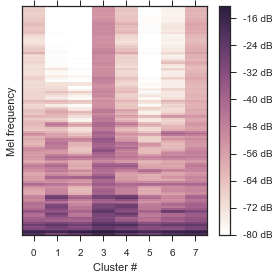

In [7]:
# We can plot the resulting centroids
plt.figure(figsize=(4, 4))

librosa.display.specshow(C.cluster_centers_.T)

plt.xticks(range(len(C.cluster_centers_)))
plt.xlabel('Cluster #')

plt.ylabel('Mel frequency')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()

In [8]:
# Now we can make predictions, in this case, frame-level cluster identifiers.
# Let's run it on the training data, just to be sure it worked.
ClusterPipe.predict([y_train])

array([5, 5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1,
       1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1,
       1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1,

In [9]:
# Now we can test it on a different portion of the track: [20s, 25s]

y_test, sr = librosa.load(librosa.util.example_audio_file(), duration=5, offset=20.0)

In [10]:
ClusterPipe.predict([y_test])

array([0, 0, 6, 6, 4, 4, 4, 6, 6, 7, 7, 0, 0, 7, 7, 7, 7, 0, 6, 6, 6, 5, 5,
       5, 6, 6, 6, 5, 5, 0, 6, 1, 7, 3, 3, 3, 3, 7, 7, 7, 7, 0, 0, 0, 0, 0,
       6, 6, 7, 7, 7, 0, 0, 0, 0, 0, 0, 5, 0, 7, 7, 6, 6, 7, 7, 0, 6, 5, 6,
       6, 6, 6, 6, 3, 3, 3, 3, 3, 7, 7, 7, 0, 0, 0, 7, 4, 1, 1, 6, 7, 7, 7,
       0, 7, 7, 7, 7, 6, 6, 6, 6, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 3, 3,
       3, 3, 3, 7, 7, 7, 0, 0, 0, 0, 6, 6, 6, 7, 7, 7, 6, 6, 0, 0, 0, 5, 5,
       4, 7, 7, 7, 7, 7, 7, 4, 0, 6, 6, 6, 6, 6, 7, 3, 3, 3, 3, 7, 7, 7, 6,
       6, 6, 7, 7, 4, 1, 1, 7, 7, 4, 0, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, 5, 6,
       6, 6, 5, 5, 6, 1, 1, 7, 3, 3, 3, 3, 7, 7, 7, 7, 0, 6, 0, 7, 0, 1, 6,
       7, 7, 7, 7, 0, 0, 0, 0, 7], dtype=int32)